# ADS Thesis Project - Random Forest - Cattle

**Authors: Marion Späth (2772981)**


This notebook documents the Random Forest for both cattle and goat herders.
The datasets have been created in the R file for the Elastic Net.

### Import libraries

In [1]:
#!pip install shap
#!pip install lightgbm 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import os

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold


# with pickle we can save the model, helps with long computation times
import pickle

### Import datasets

In [3]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/ML_training')

# load train and test data (previously created in the ElasticNet notebook)
train_cattle = pd.read_csv("train_cattle_df.csv")
test_cattle = pd.read_csv("test_cattle_df.csv")
test_cattle.head(2)

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_cattle,cs_cs_ratio_post_cattle,number_minors,educ_child_recoded,educ_child_recodedNUMERIC,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,age_constant_z,number_adults_z,number_minors_z,educ_child_z,educ_adult_z,cs_diff_log,resid_mixed
0,1,4,No,25,Yes,No,Never attended,1,No,0,1,-188.170624,0.0,2,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,Lack of Awareness or Understanding,Yes,Yes,-1.098058,-0.213343,-0.774825,-0.892525,-0.476155,5.242649,-0.429083
1,26,4,No,35,No,No,Never attended,1,No,0,0,-571.529175,0.0,3,Elementary,5,Student,Fully settled: The whole of the household (all...,2,Professional and Organizational Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.496108,-0.213343,-0.159894,0.413594,-0.476155,6.350064,0.659505


# Original Model with Education as a Categorical Variable

### Prepare Datasets for Models

Create dummies for categorical variables and split X and Y values for both test and train data.

In [4]:
# Prepare categorical variables but creating dummies
train_cattle = pd.get_dummies(train_cattle, drop_first='True')
test_cattle = pd.get_dummies(test_cattle, drop_first='True')

# Prepare X and Y training sets for models
X_cattle = train_cattle.copy
X_cattle = train_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", 
                              "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_cattle = train_cattle["resid_mixed"]

X_cattle_TEST = test_cattle.copy
X_cattle_TEST = test_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults",
                                   "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_cattle_TEST = test_cattle["resid_mixed"]

In [5]:
X_cattle.columns

Index(['expend', 'irrigated_land_bin', 'owns_phone', 'age_constant_z',
       'number_adults_z', 'number_minors_z', 'afm_language_Yes',
       'agric_land_Yes', 'amh_language_Yes',
       'educ_recoded_constant_Elementary',
       'educ_recoded_constant_Never attended', 'educ_recoded_constant_Nursery',
       'educ_recoded_constant_Secondary and Higher', 'eng_language_Yes',
       'educ_child_recoded_Never attended school', 'educ_child_recoded_Other',
       'educ_child_recoded_Secondary', 'activity_child_recoded_Not working',
       'activity_child_recoded_Student', 'activity_child_recoded_Working',
       'activity_child_recoded_Working with Livestock',
       'household_description_Not settled: The whole household moves around in order to herd the animals',
       'household_description_Partially settled: Some members of the household are permanently settled and others move around in order to herd their animals',
       'main_info_source_recoded_Media, Community-Based, and Survey So

# Random Forest

#### Set Up Hyperparameters and Performance Indicators

Prepare cross-validation using grid search including all available hyperparameters and specifying performance metrics to incluede the (negative) mean squared error, (negative) mean absolute error, and R Squared. Sklearn calculate the negative values so that the interpretation of "the higher the better" is valid across all performance metrics.

In [6]:
rf = RandomForestRegressor(random_state=0)

cv_params = {'max_depth': [5,7,10,15, None], 
             'min_samples_leaf': [2,4,6,8,10],
             'min_samples_split': [2,3,4,6,8,10],
             'max_features': [2,5,10,15],
             'n_estimators': [50, 75, 100, 125, 150,200]
             }  

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

random_forest = RandomizedSearchCV(
    estimator=rf,
    param_distributions=cv_params,
    n_iter=200,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',  # Refit the best model based on MAE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

#### Fit Model

Fit the model. Runtime is ~1hour.

In [7]:
%%time
random_forest.fit(X_cattle, Y_cattle)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


c:\anaconda_custom\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: total: 8.34 s
Wall time: 1min 42s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=0), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 10, 15, None],
                                        'max_features': [2, 5, 10, 15],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 3, 4, 6, 8,
                                                              10],
                                        'n_estimators': [50, 75, 100, 125, 150,
                                                         200]},
                   refit='mse', return_train_score=True,
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

#### Save the model

Model then does not need to be re-run, but can just be imported.

In [8]:
# Pickle the model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'random_forest_m1_CATTLEv1.pickle', 'wb') as to_write:
    pickle.dump(random_forest, to_write)

Read in model. Extract best hyperparameter specifications and best model performance.

In [9]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'random_forest_m1_CATTLEv1.pickle', 'rb') as to_read:
    random_forestm1v1 = pickle.load(to_read)

print("Best hyperparameters:\n", random_forestm1v1.best_params_ , "\n")
print("Performance based on best hyperparameter specification MSE:\n", random_forestm1v1.best_score_)

Best hyperparameters:
 {'n_estimators': 125, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': 10} 

Performance based on best hyperparameter specification MSE:
 -2.6634219530287435


### Refit Model Based on Best Model

In [ ]:
# Fit the best model on the train set
best_model = random_forestm1v1.best_estimator_
best_model.fit(X_cattle, Y_cattle)

RandomForestRegressor(max_depth=10, max_features=2, min_samples_leaf=4,
                      min_samples_split=3, n_estimators=125, random_state=0)

### Make Predictions on Test Set and Get Performance Metrics

In [11]:
# 3. Predict on the test set
y_predm1v1 = best_model.predict(X_cattle_TEST)

# 4. Evaluate performance
mae = mean_absolute_error(Y_cattle_TEST, y_predm1v1)
mse = mean_squared_error(Y_cattle_TEST, y_predm1v1)
r2  = r2_score(Y_cattle_TEST, y_predm1v1)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):  {np.sqrt(mse):.4f}")
print(f"R-squared (R²):            {r2:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 1.1907
Root Mean Squared Error (RMSE):  1.6497
R-squared (R²):            0.0053


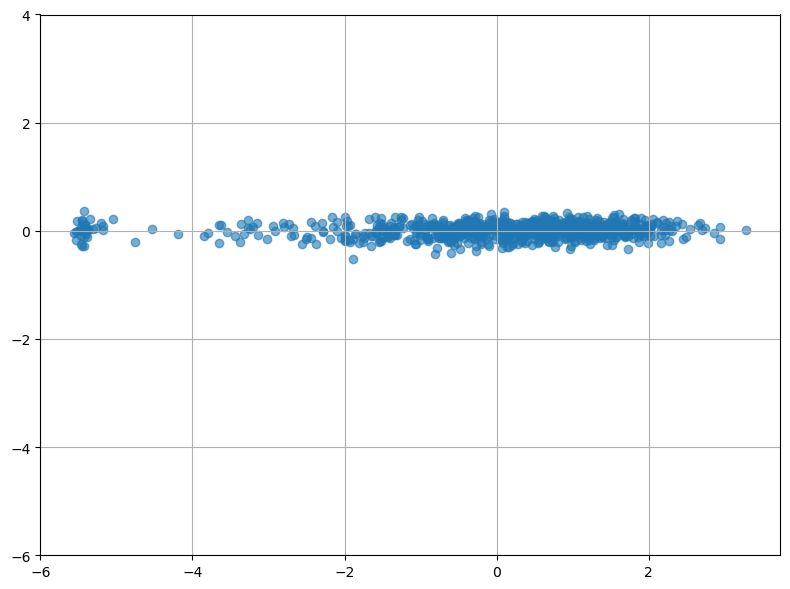

In [14]:
# Residuals = actual - predicted
residuals = Y_cattle_TEST - y_predm1v1

plt.figure(figsize=(8, 6))
plt.scatter(Y_cattle_TEST, y_predm1v1, alpha=0.6) # Y_cattle_TEST

#plt.xlabel("y_predm1v1 Values")
#plt.ylabel("Residuals (Actual - Predicted)")
#plt.title("Residuals vs. y_pred Values")
plt.ylim(-6, 4) 
plt.grid(True)
plt.tight_layout()
plt.show()


### Extract (Built-In) Feature Importance Scores

In [15]:
# Get feature importances from the best model
importances = random_forestm1v1.best_estimator_.feature_importances_

# Pair them with feature names and sort by importance
feature_names = X_cattle.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                                              Feature  Importance
3                                      age_constant_z    0.145279
5                                     number_minors_z    0.093334
4                                     number_adults_z    0.089826
2                                          owns_phone    0.038123
22  household_description_Partially settled: Some ...    0.033156
7                                      agric_land_Yes    0.032298
30  why_not_purchase_recoded_Lack of Awareness or ...    0.031708
26              religion_recoded_Traditional/Wakefata    0.031690
29  why_not_purchase_recoded_Financial, Practical,...    0.031352
24  main_info_source_recoded_Professional and Orga...    0.030319
27                                household_moved_Yes    0.027565
18                     activity_child_recoded_Student    0.027364
23  main_info_source_recoded_Media, Community-Base...    0.027293
0                                              expend    0.025521
25        

## Shap

### Investigate Partial Dependences and Interactions

c:\anaconda_custom\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


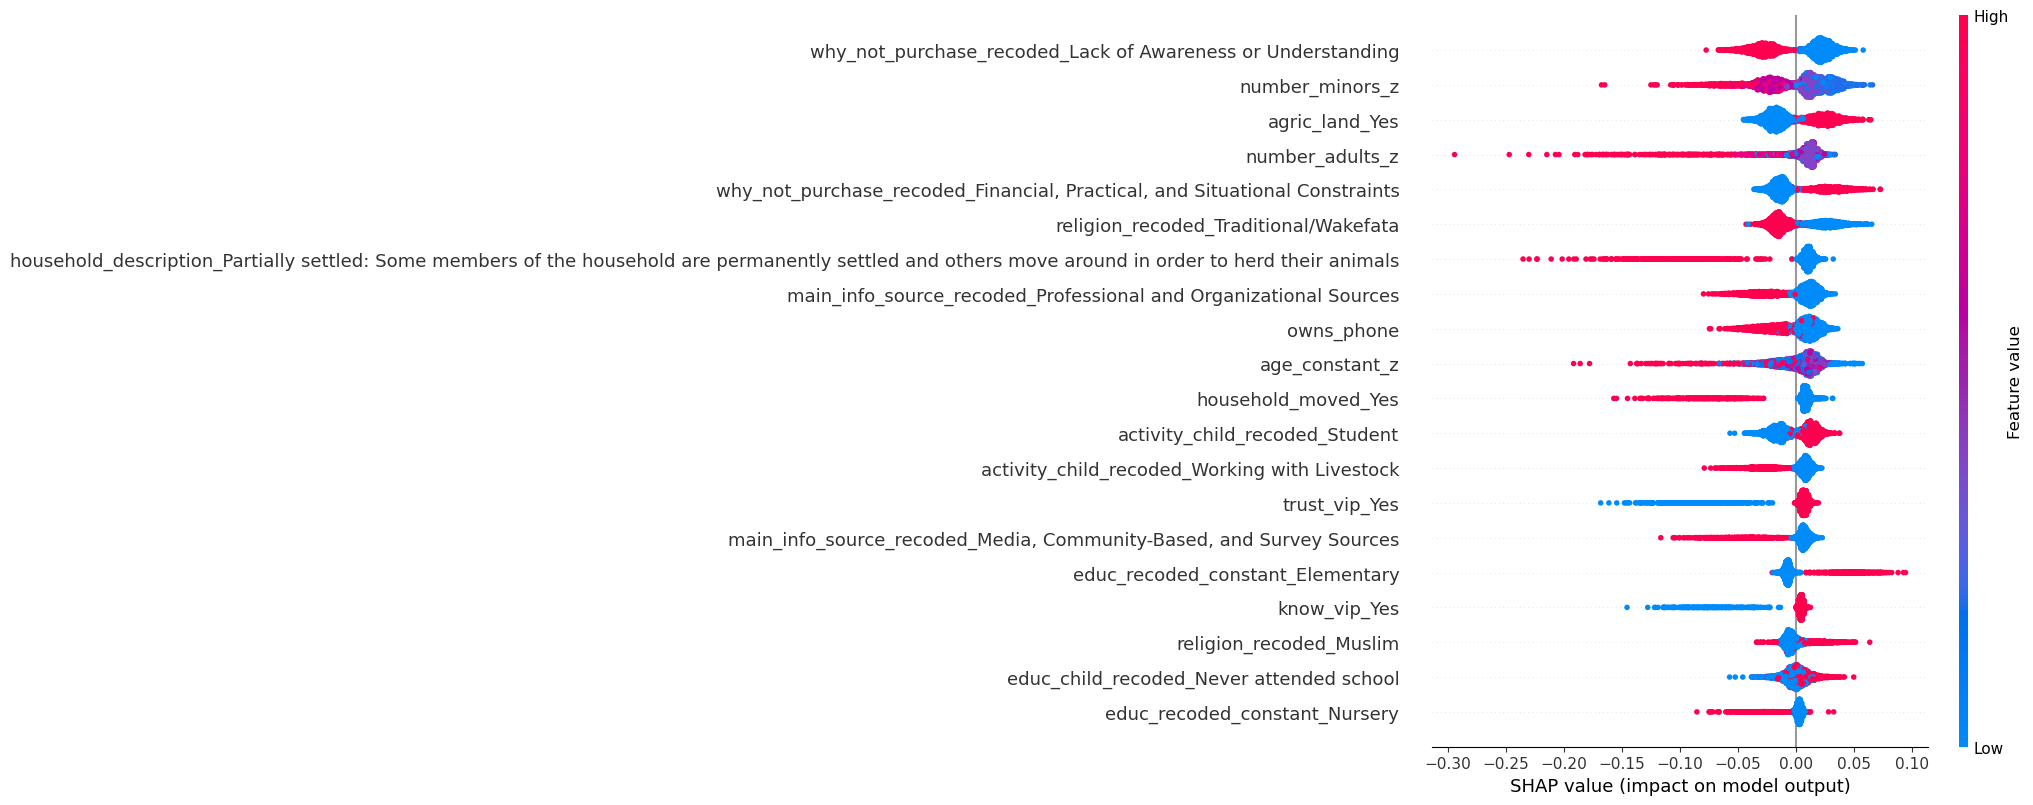

In [16]:
# 1. Best model
best_model = random_forestm1v1.best_estimator_

# 2. Explainer
explainer = shap.TreeExplainer(best_model)

# 4. Compute SHAP values
shap_values = explainer.shap_values(X_cattle)

# Plot SHAP summary
shap.summary_plot(
    shap_values,
    X_cattle,
    plot_type="dot",
)

# Refit using Education Variables as Numeric Variables

Goal: By (slightly) reducing the number of categorical variables, and increasing the number of numeric variables, the R2 might be increased. 

In [17]:
# load train and test data (previously created in the ElasticNet notebook)
train_cattle = pd.read_csv("train_cattle_df.csv")
test_cattle = pd.read_csv("test_cattle_df.csv")

In [45]:
train_cattle.columns

Index(['id', 'wave', 'afm_language', 'age_constant', 'agric_land',
       'amh_language', 'educ_recoded_constant', 'educ_recoded_constant_num',
       'eng_language', 'expend', 'irrigated_land_bin',
       'cs_cs_diff_post_cattle', 'cs_cs_ratio_post_cattle', 'number_minors',
       'educ_child_recoded', 'educ_child_recodedNUMERIC',
       'activity_child_recoded', 'household_description', 'number_adults',
       'main_info_source_recoded', 'religion_recoded', 'owns_phone',
       'household_moved', 'why_not_purchase_recoded', 'know_vip', 'trust_vip',
       'age_constant_z', 'number_adults_z', 'number_minors_z', 'educ_child_z',
       'educ_adult_z', 'cs_diff_log', 'resid_mixed'],
      dtype='object')

In [18]:
# Prepare X and Y training sets for models
X_cattle = train_cattle.copy
X_cattle = train_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", "educ_recoded_constant", "educ_child_recoded",
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_cattle = train_cattle["resid_mixed"]

X_cattle_TEST = test_cattle.copy
X_cattle_TEST = test_cattle.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_cattle", "cs_cs_ratio_post_cattle", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", "educ_recoded_constant", "educ_child_recoded",
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_cattle_TEST = test_cattle["resid_mixed"]

In [19]:
# Prepare categorical variables but creating dummies
X_cattle = pd.get_dummies(X_cattle, drop_first='True')
X_cattle_TEST = pd.get_dummies(X_cattle_TEST, drop_first='True')
X_cattle_TEST.columns

Index(['expend', 'irrigated_land_bin', 'owns_phone', 'age_constant_z',
       'number_adults_z', 'number_minors_z', 'educ_child_z', 'educ_adult_z',
       'afm_language_Yes', 'agric_land_Yes', 'amh_language_Yes',
       'eng_language_Yes', 'activity_child_recoded_Not working',
       'activity_child_recoded_Student', 'activity_child_recoded_Working',
       'activity_child_recoded_Working with Livestock',
       'household_description_Not settled: The whole household moves around in order to herd the animals',
       'household_description_Partially settled: Some members of the household are permanently settled and others move around in order to herd their animals',
       'main_info_source_recoded_Media, Community-Based, and Survey Sources',
       'main_info_source_recoded_Professional and Organizational Sources',
       'religion_recoded_Muslim', 'religion_recoded_Traditional/Wakefata',
       'household_moved_Yes',
       'why_not_purchase_recoded_Distrust or Negative Perception',


In [23]:
rf = RandomForestRegressor(random_state=0)

cv_params = {'max_depth': [5,7,10,15, None], 
             'min_samples_leaf': [2,4,6,8,10],
             'min_samples_split': [2,3,4,6,8,10],
             'max_features': [2,5,10,15],
             'n_estimators': [50, 75, 100, 125, 150,200]
            }  

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

random_forestm2 = RandomizedSearchCV(
    estimator=rf,
    param_distributions=cv_params,
    n_iter=200,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',  # Refit the best model based on MAE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

In [24]:
%%time
random_forestm2.fit(X_cattle, Y_cattle)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
CPU times: total: 7.77 s
Wall time: 1min 46s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=0), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 10, 15, None],
                                        'max_features': [2, 5, 10, 15],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 3, 4, 6, 8,
                                                              10],
                                        'n_estimators': [50, 75, 100, 125, 150,
                                                         200]},
                   refit='mse', return_train_score=True,
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

In [25]:
# Pickle the model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'random_forest_m2_CATTLEv1.pickle', 'wb') as to_write:
    pickle.dump(random_forestm2, to_write)

In [26]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'random_forest_m2_CATTLEv1.pickle', 'rb') as to_read:
    random_forestm2v1 = pickle.load(to_read)

print("Best hyperparameters:\n", random_forestm2v1.best_params_ , "\n")
print("Performance based on best hyperparameter specification MSE:\n", random_forestm2v1.best_score_)

Best hyperparameters:
 {'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 5, 'max_depth': 5} 

Performance based on best hyperparameter specification MSE:
 -2.6605218463831166


In [27]:
# 3. Predict on the test set
y_predm2v1 = random_forestm2v1.predict(X_cattle_TEST)

# 4. Evaluate performance
mae = mean_absolute_error(Y_cattle_TEST, y_predm2v1)
mse = mean_squared_error(Y_cattle_TEST, y_predm2v1)
r2  = r2_score(Y_cattle_TEST, y_predm2v1)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):  {np.sqrt(mse):.4f}")
print(f"R-squared (R²):            {r2:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 1.1852
Root Mean Squared Error (RMSE):  1.6482
R-squared (R²):            0.0071


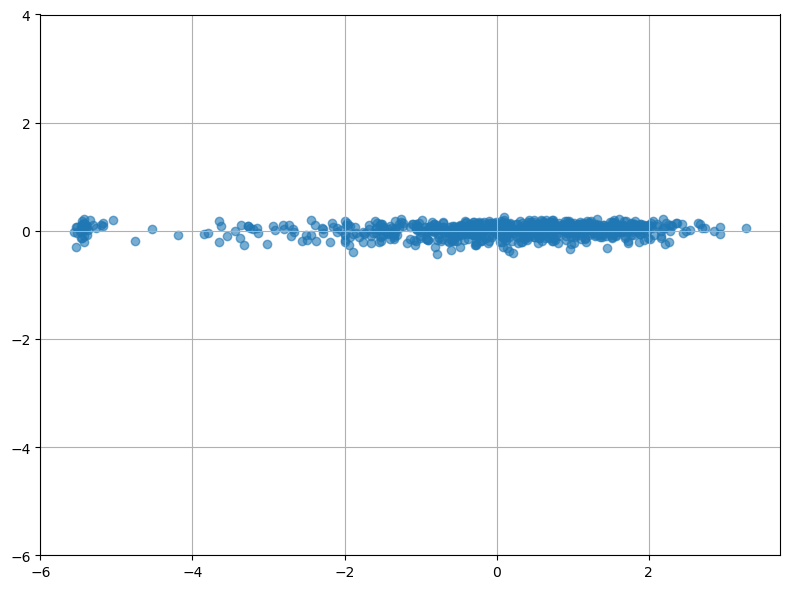

In [29]:
# Residuals = actual - predicted
residuals = Y_cattle_TEST - y_predm2v1

plt.figure(figsize=(8, 6))
plt.scatter( Y_cattle_TEST, y_predm2v1, alpha=0.6) # Y_cattle_TEST

#plt.xlabel("y_predm1v1 Values")
#plt.ylabel("Residuals (Actual - Predicted)")
#plt.title("Residuals vs. y_pred Values")
plt.ylim(-6, 4) 
plt.grid(True)
plt.tight_layout()
plt.show()
